In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import LGTp as lgt

# Review of Extending machine learning classification capabilities with histogram reweighting  
  
ref : [Bachtis, Aarts, Lucini, Phys. Rev. E 102, 033303](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.102.033303)

This note is to review and reproduce phase detection using machine learning with histogram reweighting.  It will be done by following procedure.  
1. We define Ising model action and generate Ising model configurations using Wolff algorithm for traning and validation.  
2. Build CNN layers proposed in the ref and train using the Ising model configurations
3. Summarize about histogram reweighting and apply it to CNN output

In [2]:
T_hist = []
M_hist = []
M_err_hist = []
N = 16

## 1. Autocorrelation test

In [18]:
def calcEnergy(config):
    energy = 0
    
    for i in range(len(config)):
        for j in range(i):
            s = config[i,j]
            nn = config[(i+1)%N,j]
            + config[(i-1)%N,j]
            + config[i,(j+1)%N]
            + config[i,(j-1)%N]
            energy += -nn*s
    return energy

def calcMag(config):
    mag = np.abs(np.average(config))
    #mag = np.average(config)
    return mag

In [60]:
ising1 = lgt.Lattice([N,N])
ising2 = lgt.Lattice([N,N])

In [61]:
ising1.init_fields('Ising','Cold')
ising2.init_fields('Ising','Hot')

In [62]:
calcMag(ising1.field)

1.0

In [63]:
ising1.field.shape

(16, 16)

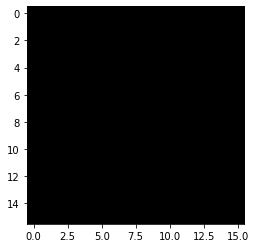

In [64]:
plt.imshow(ising1.field,cmap='gray')

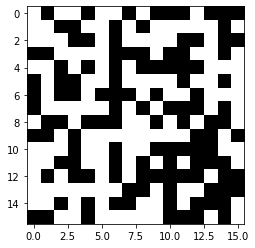

In [65]:
plt.imshow(ising2.field,cmap='gray')

In [66]:
# started 0 increasing by 1
T = np.linspace(1.53,3.28,32)
bare_parameters = {'beta':1./T[1], 'J':1., 'h':0.00, 'mu':0.1}

In [ ]:
# Equilibrating phase

ising1 = lgt.Lattice([N,N])
ising2 = lgt.Lattice([N,N])

ising1.init_fields('Ising','Cold')
ising2.init_fields('Ising','Hot')

M_cold = []
M_hot = []

n_equi_test = 1000
for i in range(n_equi_test):

    M_cold.append(calcMag(ising1.field))
    M_hot.append(calcMag(ising2.field))
    
    lgt.metropolis(ising1,bare_parameters)
    lgt.metropolis(ising2,bare_parameters)
    


In [ ]:
plt.title("Estimation of autocorrelation time")
plt.plot(np.arange(n_equi_test),M_cold,'C0',label='cold')
plt.plot(np.arange(n_equi_test),M_hot,'C3',label='hot')
plt.legend(loc='upper right')

In [46]:
# autocorrelation time
t_a = n_equi_test

In [47]:
t_a

50

In [48]:
ising = lgt.Lattice([N,N])
ising.init_fields('Ising','Cold')

n_equi = 2*t_a
for i in range(n_equi):
    lgt.metropolis(ising,bare_parameters)
    
conf = []
for e in range(100):
    lgt.metropolis(ising,bare_parameters)
    conf.append(ising.field)
    
# for i in range(n_equi):
#     g = G.transform()
#     new_field = old_field*g
#     old_field = new_field

# old_field = new_field

# plt.imshow(old_field, cmap='gray')
# plt.show()

# conf = []
# for e in range(100):
#     S_diff = 0.
#     accept = 0

#     for i in range(16*16):
#         g = G.transform()
#         new_field = old_field*g
#         S_diff += G.DS(old_field, new_field)
        
#         r = np.random.uniform(0,1)
#         Ta = min(1, np.exp(-beta*S_diff))
#         if Ta >= r:
#             accept = 1
#             old_field = new_field

#     conf.append(old_field)

In [49]:
len(conf)

100

In [50]:
# S_list = []
# for i in range(100):
#     S_list.append(G.S(conf[i]))

In [51]:
# plt.hist(S_list, bins=20)

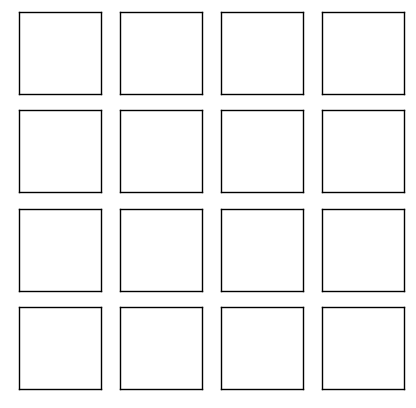

In [52]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(conf[ind], vmin=-1, vmax=1, cmap='gray')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
    
plt.show()

In [53]:
# Measure
M = []
for i in range(len(conf)):
    M.append(calcMag(conf[i]))

In [54]:
np.fabs(np.mean(M))

0.99984375

In [55]:
np.std(M)

0.0010937499999999999

In [56]:
T_hist.append(1./bare_parameters['beta'])
M_hist.append(np.fabs(np.mean(M)))
M_err_hist.append(np.std(M))

In [57]:
len(T_hist)

2

<ErrorbarContainer object of 3 artists>

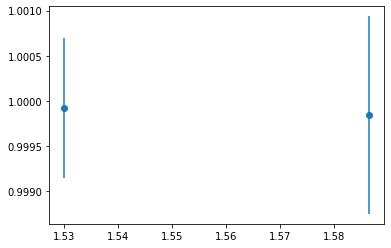

In [59]:
plt.errorbar(T_hist, M_hist, yerr=M_err_hist, fmt='C0o')